In [1]:
import os
import sys
import numpy as np
from skimage import data, io, filters, transform
from skimage.transform import resize
import pandas as pd
import shutil
import matplotlib
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.models import load_model
from keras import backend as K
from keras import applications
from keras import optimizers
from keras.preprocessing import image
import warnings
import scipy
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

/home/heinemfa/anaconda3/envs/kerasGPU/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Script to show class activation maps

Ref: https://www.cv-foundation.org/openaccess/content_cvpr_2016/html/Zhou_Learning_Deep_Features_CVPR_2016_paper.html

In [2]:
""" Set parameters for input and output of the prediction
"""

# Base path
model_base_path = "./model" # Specify your local repository base path here

base_path = model_base_path + "/Liver/NAS/ballooning/"
#base_path = model_base_path + "/Liver/NAS/inflammation/"
#base_path = model_base_path + "/Liver/NAS/steatosis/"
#base_path = model_base_path + "/Liver/fibrosis/"

# Path of images

predict_base_path = "./class_activation_map_images/"

# Path of DL model
model_name = base_path + "model/Liver_ballooning_model_V0.9.h5"
#model_name = base_path + "model/Liver_inflammation_model_V0.9.h5"
#model_name = base_path + "model/Liver_steatosis_model_V0.9.h5"
#model_name = base_path + "model/Liver_fibrosis_Model_2019.07.05.h5"

# Image dimensions
img_width, img_height = 299, 299

# Num classes
num_classes = 3

# Class to be highlighted
class_of_interest = 1

In [3]:
def get_trained_model():
    """ Prepare CNN for prediction and get trained model
    
    Returns:        
        InceptionV3_model: Keras model object with two outputs
                           ((1) last conv layer, (2) softmax output)
        amp_weights: Weights bewtween dense layer and fully connected layer
    """

    K.clear_session()

    input_shape = (img_width, img_height, 3)

    # Define base model (Inception V3, trained on image net, without top layers)
    image_net_base_model = applications.InceptionV3(weights = 'imagenet', include_top = False, input_shape = input_shape)
    
    # Define top model  
    input_tensor = Input(shape = input_shape)

    bn = BatchNormalization()(input_tensor)
    x = image_net_base_model(bn)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(input_tensor, output)

    # Load weights of pre-trained model
    model.load_weights(model_name)    

    # Compile the model
    model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.SGD(lr = 0.5e-4, momentum = 0.9), metrics = ['accuracy'])
    
    # https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer        
    InceptionV3_model = Model(inputs=model.input, outputs = (model.layers[-3].input, model.layers[-1].output))
    
    # Weights of the dense layer
    dense_weights = model.layers[-1].get_weights()[0]
    
    return InceptionV3_model, dense_weights

In [4]:
def get_predict_generator(predict_path):
    """ Get the Keras predict generator
    Args:
        Predict path (string): path containing the image location
    
    Return:
        predict_datagen object
    """
    
    predict_datagen = ImageDataGenerator(rescale=1./255)

    # Predict generator
    predict_generator = predict_datagen.flow_from_directory(
        predict_path,
        target_size = (img_width, img_height),
        batch_size = 1,
        class_mode = None,
        shuffle = False)

    return predict_generator

In [5]:
# Prepare network and get model object
print("Loading model...")
InceptionV3_model, dense_weights = get_trained_model()
print("Model %s loaded." % (model_name))

Loading model...
Model ./model/Liver/NAS/ballooning/model/Liver_ballooning_model_V0.9.h5 loaded.


Found 2 images belonging to 1 classes.


/home/heinemfa/anaconda3/envs/kerasGPU/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


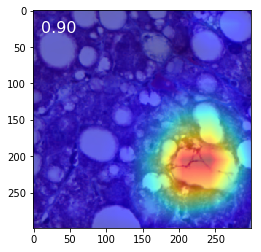

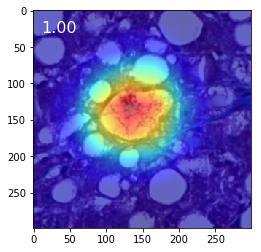

In [7]:
predict_generator = get_predict_generator(predict_base_path)

# Load images in folder into dataframe
data = pd.DataFrame()

# extract features
first_run = True

# Counter
index = 0

for img in predict_generator:
    if (first_run == False and (predict_generator.batch_index -1) == 0):
        break
    
    # Get classification for current_image
    last_conv_layer, classification_layer = InceptionV3_model.predict(img)
    
    # Remove dimensions with only one entry from array shape
    last_conv_layer = np.squeeze(last_conv_layer)    
    
    # Get prediction
    prediction = np.argmax(classification_layer)    
    
    # Get weights of dense layer for class_of_interest
    dense_weights_curent_class = dense_weights[:, class_of_interest]
    
    # Dot product of last conv layer (8,8,2048) with dense_weights_current_class (2048,,)
    class_activation_map = np.dot(last_conv_layer, dense_weights_curent_class)
    
    # Normalize to -1 1 and rescale to 299, 299
    class_activation_map_resized = resize((class_activation_map - class_activation_map.min())/(class_activation_map.max() - class_activation_map.min()), (299,299))
    
    plt.figure()
    plt.imshow(np.squeeze(img))
    plt.imshow(class_activation_map_resized, cmap = "jet", alpha = 0.6)
        
    save_file = predict_base_path + predict_generator.filenames[index][:-4] + "_cam.png"    
    
    text_str = "{:.2f}".format(classification_layer[0, class_of_interest])
    plt.text(10,30, text_str, fontsize = 16, color = "white")
    
    plt.savefig(save_file, dpi = 600)
    plt.show()
    
    if (first_run):
        first_run = False
        
    index = index + 1